## USEFUL PACKAGES

In [1]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
import emoji
import re
from itertools import cycle
%matplotlib inline
import seaborn as sns
import plotly.express as px
import warnings
# Para tratamientos de texto
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import spacy
import es_core_news_md
from spellchecker import SpellChecker

# Modelos Scikit-learn
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,HistGradientBoostingClassifier,GradientBoostingClassifier,StackingClassifier

# Evaluacion
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,balanced_accuracy_score,precision_score,f1_score,average_precision_score
from sklearn.metrics import roc_curve,auc, roc_auc_score
from sklearn.metrics import RocCurveDisplay



#---------------------------------------------------------------------------------#
warnings.filterwarnings('ignore')

In [2]:
def read_dataset(path):
    tree = ET.parse(path)
    root = tree.getroot()
    value = []
    for sentiment in root.iter('sentiment'):
        for polarity in sentiment.iter('polarity'):
            for deep_tag in polarity:
            #print(deep_tag.text)
                value.append(deep_tag.text)
    df = pd.read_xml(path)
    df['sentiment'] = value
    return df

## Corpus 2018

In [3]:
df_train_2018 = pd.DataFrame()
for filename in os.listdir('../data2018/train/'):
    df_initial_2018 = read_dataset('../data2018/train/'+filename)
    df_train_2018 = pd.concat([df_train_2018,df_initial_2018])
df_train_2018 = df_train_2018[['tweetid', 'content', 'sentiment']]
df_train_2018.columns = ['id', 'tweet', 'classification']

## CORPUS 2019

In [4]:
df_train_2019 = pd.DataFrame()
for filename in os.listdir('../data2019/train/'):
    df_initial_2019 = read_dataset('../data2019/train/'+filename)
    df_train_2019 = pd.concat([df_train_2019,df_initial_2019])
df_train_2019 = df_train_2019[['tweetid', 'content', 'sentiment']]
df_train_2019.columns = ['id', 'tweet', 'classification']

## DATASET 2020

In [5]:
df_initial_1 = pd.DataFrame()
for filename in os.listdir('../data/train/'):
    df_country = pd.read_csv('../data/train/'+ filename, sep='\t', names=['id','tweet','classification'])
    #df_country['fuente'] = filename+'train'
    df_initial_1 = pd.concat([df_initial_1, df_country])
df_initial_2 = pd.DataFrame()
for filename in os.listdir('../data/dev/'):
    df_country = pd.read_csv('../data/dev/'+ filename, sep='\t', names=['id','tweet','classification'])
    #df_country['fuente'] = filename+'dev'
    df_initial_2 = pd.concat([df_initial_2, df_country])

df_initial = pd.concat([df_initial_1,df_initial_2])
df_initial = df_initial.drop_duplicates(subset='id')
df_initial = df_initial.replace({'classification':{'N':0,'NEU':1,'P':2}})
df_initial.head(1)

,id,tweet,classification
0,809927403615256576,En definitiva! Me quedé sin campo para ir a Ta...,0


In [6]:
df_final_test = pd.DataFrame()
for filename in os.listdir('../data/test/'):
    df_country_test = pd.read_csv('../data/test/'+ filename, sep='\t', names=['id','tweet'])
    #df_country_test['fuente'] = filename+'test'
    df_final_test = pd.concat([df_final_test, df_country_test])

df_final_sentiment = pd.DataFrame()
for filename in os.listdir('../data/testgold/'):
    df_country_testgold = pd.read_csv('../data/testgold/'+ filename, sep='\t', names=['id','classification'])
    #df_country_testgold['fuente'] = filename+'test'
    df_final_sentiment = pd.concat([df_final_sentiment, df_country_testgold])

df_final = df_final_test.merge(df_final_sentiment, how = 'left', on = 'id')   
df_final = df_final.replace({'classification':{'N':0,'NEU':1,'P':2}})
df_final = df_final.drop_duplicates(subset='id')


In [7]:
df_final.groupby('classification').count()

,id,tweet
classification,,
0,2939,2939
1,1966,1966
2,2359,2359


In [8]:
df_final.shape

(7264, 3)

In [9]:
df_initial.groupby('classification').count()

,id,tweet
classification,,
0,2835,2835
1,2315,2315
2,2093,2093


0    2835
1    2315
2    2093
Name: classification, dtype: int64
Tamaño del dataset: (7243, 3)


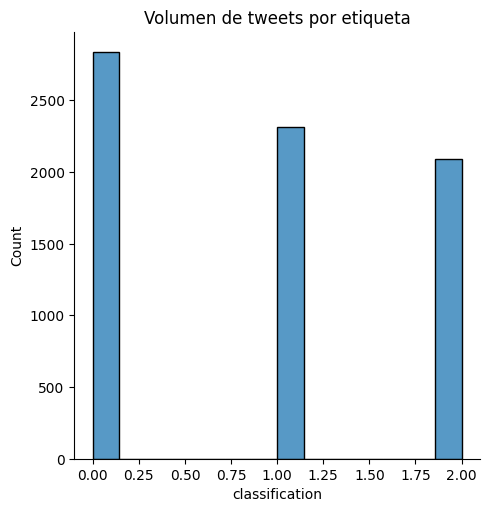

In [10]:
# Comprobamos distribución de la etiqueta 'classification'
sns.displot(df_initial.classification)
plt.title('Volumen de tweets por etiqueta');
print(df_initial.classification.value_counts())
print('Tamaño del dataset:', df_initial.shape)

(0.0, 40.0)

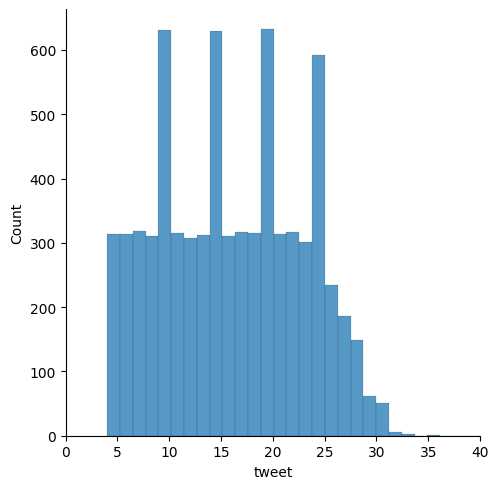

In [11]:
def count_words(df):
    count = 0
    for word in df.split():
        count += 1
    return count
#------------------------------------------------------------------------------------#
## recortar el eje x hasta 100 para mejorar la visualizacion.
ax = sns.displot(df_initial['tweet'].apply(count_words))
plt.xlim(0,40)

### Funciones para tratamiento de datos


* Debemos tener que estos tweets no están normalizados y por lo tanto debemos diseñar funciones que no permitan normalizar las expreciones escritas, quitar, emojis y corregir algunas otras cosas para no tener palabras que aunque signifiquen lo mismo parezcan diferentes.

In [12]:
# Eliminamos signos de puntuación y sustituimos por espacios en blanco

def remove_punctuation_space(df):
    PUNCTUATION = re.compile("""(\-)|(\,)|(\..)|(\...)|(\....)|(\.....)|(\......)|(\.......)""")
    
    return " ".join([PUNCTUATION.sub(" ", word.lower()) for word in df.split()])

In [13]:
# Eliminamos signos de puntuación sin reemplazo

def remove_punctuation(df):
    PUNCTUATION = re.compile("""(\.)|(\;)|(\:)|(\!)|(\?)|(\¡)|(\¿)| \
    (\")|(\()|(\))|(\[)|(\])|(\d+)|(\/)|(\“)|(\”)|(\')|(\-)|(\")|(\*)""")
    
    return " ".join([PUNCTUATION.sub("", word.lower()) for word in df.split()])

In [14]:
# Corregimos abreviaciones
def fix_abbr(x):
    if type(x) == list:
        words = x
    elif type(x) == str:
        words = x.split()
    else:
        raise TypeError('El formato no es válido, debe ser lista o str')

    abbrevs = {'d': 'de',
               'x': 'por',
               'xa': 'para',
               'as': 'has',
               'q': 'que',
               'k': 'que',
               'dl': 'del',
               'xq': 'porqué',
               'dr': 'doctor',
               'dra': 'doctora',
               'sr': 'señor',
               'sra': 'señora',
               'm': 'me'}
    return " ".join([abbrevs[word] if word in abbrevs.keys() else word for word in words])

In [15]:

# Sustituimos links por {link}
def remove_links(df):
    return " ".join(['{link}' if ('http') in word else word for word in df.split()])

In [16]:
# Eliminamos vocales repetidas
    
def remove_repeated_vocals(df):
    
    list_new_word = []

    for word in df.split(): #separamos en palabras
        new_word = []
        pos = 0
        
        for letra in word: #separamos cada palabra en letras
            #print(word, letra, pos, '-', new_word)
            if pos>0:
                if letra in ('a', 'e', 'i', 'o', 'u') and letra == new_word[pos-1]:
                    None
                else:
                    new_word.append(letra)
                    pos +=1
            else:
                new_word.append(letra)
            
                pos += 1
        else:
            list_new_word.append("".join(new_word))
                
    return " ".join(list_new_word)

In [17]:
# Normalizamos risas 'jajaja', 'jejeje', 'jojojo'
    
def normalize_laughts(df):
    
    list_new_words = []
    for word in df.split(): #separamos en palabras
        count = 0
        vocals_dicc = {'a': 0, 'e': 0, 'i': 0, 'o':0, 'u':0}
        
        for letra in word:
            #print(word)
            if letra == 'j':
                count+=1
            if letra in vocals_dicc.keys():
                vocals_dicc[letra] += 1
        else:
            if count>3:
                dicc_risa = {'a': 'jaja', 'e': 'jeje', 'i': 'jiji', 'o': 'jojo', 'u': 'juju'}
                risa_type = max(vocals_dicc, key= lambda x: vocals_dicc[x]) #Indica si es a,e,i,o,u
                list_new_words.append(dicc_risa[risa_type])
            else:
                list_new_words.append(word)
    
    return " ".join(list_new_words)

In [18]:
# Sustituimos hashtag por {hash}
def remove_hashtags(df):
    return " ".join(['{hash}' if word.startswith('#') else word for word in df.split()])

In [19]:
# Sustituimos menciones por {mencion}
def remove_mentions(df):
    return " ".join(['{menc}' if word.startswith('“@') or word.startswith('@') else word for word in df.split()])

In [20]:
# Función para identificar los 'emojis' tradicionales

def transform_icons(df):
    word_list = []
    pos_emojis = [':)', ':D', ':))', ':)))', 'xD', 'xd', 'XD']
    neg_emojis = [':(', ":'(", '>:(', ':,(', ":(("]
    for word in df.split():
        if word in neg_emojis:
            word = '{emoji_neg}'
            word_list.append(word)
        elif word in pos_emojis:
            word = '{emoji_pos}'
            word_list.append(word)
        elif ':O' in word:
            word = '{emoji_neu}'
            word_list.append(word)
        else:
            word_list.append(word)
    return " ".join(word_list)

In [21]:
# Separamos emojis que vengan juntos
def sep_emojis(df):
    words_list = []
    for token in df.split():
        new_word = []
        for letra in token:
            if letra in emoji.UNICODE_EMOJI['es']:
                words_list.append(letra)
            else:
                new_word.append(letra)
        else:
            words_list.append("".join(new_word))

    return (" ".join(word for word in words_list if word != ''))

In [22]:
# Eliminamos stopwords
nltk.download('stopwords')
spanish_stopwords = stopwords.words('spanish')
non_stopwords = ['no', 'ni', 'poco', 'mucho', 'nada', 'muchos', 'muy', 'nosotros',
                 'nosotras', 'vosotros', 'vosotras', 'ellos', 'ellas', 'ella', 'él', 'tu', 'tú', 'yo',
                 'pero', 'hasta', 'contra', 'por']
spanish_stopwords = [word for word in stopwords.words('spanish') if word not in non_stopwords]

def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in spanish_stopwords])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\smath\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Función para stemizar
def stem(df):
    stemmer = SnowballStemmer('spanish')
    return " ".join([stemmer.stem(word) for word in df.split()])

In [24]:
# Función para lematizar
# Creamos el objeto
spacy.prefer_gpu() # or spacy.require_gpu()
nlp = spacy.load("es_core_news_md")


# Definimos función
def lemmatizer(df):
    word_list = []
    doc = nlp(df)
    for tok in doc:
        if str(tok) == 'menc':
              word_list.append('{menc}')
        elif str(tok) == 'hash':
              word_list.append('{hash}')
        elif str(tok) == 'link':
              word_list.append('{link}')
        elif str(tok) == 'emoji_pos':
              word_list.append('{emoji_pos}')
        elif str(tok) == 'emoji_neu':
              word_list.append('{emoji_neu}')
        elif str(tok) == 'emoji_neg':
              word_list.append('{emoji_neg}')
        elif str(tok) == 'eur':
              word_list.append('{eur}')
        else:
            word_list.append(tok.lemma_.lower())

    return " ".join([word for word in word_list if (word != '{') and (word!='}')])  

In [25]:
# Función para corregir las palabras

spell = SpellChecker(language='es', distance=1)

def correcting_words(df):
    misspelled = spell.unknown(df.split())
    return " ".join(filter(None,[spell.correction(word) if word in misspelled else word for word in df.split()]))

In [26]:
def remove_eur(df):
    wlist = ['{eur}' if ('€' in word) | ('euro' in word) | ('$' in word) else word for word in df.split()]
    return " ".join(wlist)

In [27]:
# Put it all together

def transform_tweets(df, mode='lemma'):
    
    df = remove_links(df)
    df = remove_punctuation_space(df)
    df = remove_mentions(df)    
    df = remove_hashtags(df)
    df = remove_eur(df)
    df = transform_icons(df)
    df = sep_emojis(df)
   # df = transform_emoji(df)
    df = normalize_laughts(df)
    df = remove_punctuation(df)
    df = remove_repeated_vocals(df)
    df = correcting_words(df)
    df = fix_abbr(df)
    df = remove_stopwords(df)
    if mode=='lemma':
        df = lemmatizer(df)
    elif mode=='stem':
        df = stem(df)
    else:
        raise TypeError('Invalid mode. Must be "lemma" or "stem"') 
    df = remove_stopwords(df)                    
    return df

El stemizado es mejor para usar en ingles, es mejor el lemetizado para lenguas romance

In [28]:
print('Tweet original:\n', df_initial.tweet[50:51].iloc[0])
print('Tweet lematizado:\n', df_initial.tweet[50:51].apply(transform_tweets, mode='lemma').iloc[0])
print('Tweet stemizado:\n',df_initial.tweet[50:51].apply(transform_tweets, mode='stem').iloc[0])

Tweet original:
 Nos encanta hacerte feliz @rubndu
Tweet lematizado:
 encantar hacer tú feliz
Tweet stemizado:
 encant hacert feliz


In [29]:
%%time
# Aplicamos
df_initial['tweet_'] = df_initial.tweet.apply(transform_tweets, mode='lemma')
df_final['tweet_'] = df_final.tweet.apply(transform_tweets, mode='lemma')

CPU times: total: 38.8 s
Wall time: 49.6 s


In [30]:
df_initial = df_initial.reset_index()
df_initial = df_initial[['id', 'tweet', 'classification', 'tweet_']]

In [31]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.311-b11, mixed mode)
  Starting server from C:\Users\smath\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\smath\AppData\Local\Temp\tmpgqvs7iav
  JVM stdout: C:\Users\smath\AppData\Local\Temp\tmpgqvs7iav\h2o_smath_started_from_python.out
  JVM stderr: C:\Users\smath\AppData\Local\Temp\tmpgqvs7iav\h2o_smath_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Bogota
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_smath_7hs1ki
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.096 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [32]:
X_train, y_train = df_initial['tweet_'], df_initial['classification']
X_test, y_test = df_final['tweet_'], df_final['classification']
y_test_binarize = label_binarize(y_test,classes=[0,1,2])

# Modelos 

In [67]:

# Vectorizamos
from sklearn.feature_extraction.text import CountVectorizer

# Creamos objeto y entrenamos
df_vectorizer = CountVectorizer(binary = True,
                                      ngram_range=(1, 1))
df_vectorizer.fit(X_train)

# Transformamos X en sparse vector
X_train_vec = df_vectorizer.transform(X_train)
X_test_vec = df_vectorizer.transform(X_test)

In [69]:
count_vect_df = pd.DataFrame(X_train_vec.todense(), columns=df_vectorizer.get_feature_names_out())
train = count_vect_df
train['y'] = y_train
train_ = h2o.H2OFrame(train, column_names=train.columns.to_list(), column_types = {'y': 'enum'})
train_ = train_.na_omit()
X_train = train_.columns
y_train = 'y'
X_train.remove(y)

In [89]:
aml = H2OAutoML(max_models=40, seed=1)
aml.train(x=X_train, y=y_train, training_frame=train_)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |
16:02:45.485: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


model_id,mean_per_class_error,logloss,rmse,mse
StackedEnsemble_AllModels_1_AutoML_1_20230430_160245,0.32315,0.894727,0.576353,0.332183
StackedEnsemble_BestOfFamily_1_AutoML_1_20230430_160245,0.323293,0.906571,0.580039,0.336445
GBM_grid_1_AutoML_1_20230430_160245_model_1,0.329354,0.992015,0.606521,0.367868
GBM_grid_1_AutoML_1_20230430_160245_model_8,0.329956,0.99137,0.605323,0.366416
GBM_grid_1_AutoML_1_20230430_160245_model_10,0.330062,0.984671,0.605732,0.366911
GBM_grid_1_AutoML_1_20230430_160245_model_5,0.331928,1.00604,0.608048,0.369723
GBM_grid_1_AutoML_1_20230430_160245_model_3,0.332165,0.989136,0.611475,0.373901
GBM_grid_1_AutoML_1_20230430_160245_model_13,0.332793,0.993663,0.605719,0.366896
GBM_2_AutoML_1_20230430_160245,0.3329,0.985458,0.609411,0.371382
GBM_3_AutoML_1_20230430_160245,0.332989,0.985639,0.608474,0.37024


In [91]:
count_vect_df_2 = pd.DataFrame(X_test_vec.todense(), columns=df_vectorizer.get_feature_names_out())
test = count_vect_df_2
test['y'] = y_testtest = count_vect_df_2
test['y'] = y_test
test_ = h2o.H2OFrame(test, column_names=test.columns.to_list(), column_types = {'y': 'enum'})
test_ = test_.na_omit()

In [125]:
m = aml.get_best_model()
preds = m.predict(test_)
df_salida = preds.as_data_frame()

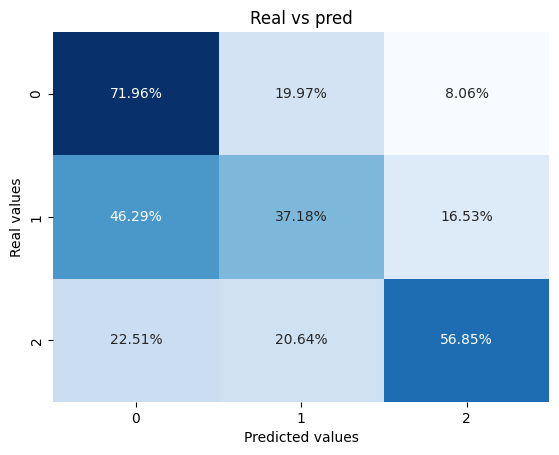

In [128]:
sns.heatmap(confusion_matrix(y_test,df_salida.predict, normalize = 'true'),
            annot=True,fmt='.2%', cmap = 'Blues', cbar = False);

plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

In [130]:
print(classification_report(y_test,df_salida.predict))

              precision    recall  f1-score   support

           0       0.59      0.72      0.65      2939
           1       0.40      0.37      0.39      1966
           2       0.70      0.57      0.63      2359

    accuracy                           0.58      7264
   macro avg       0.57      0.55      0.56      7264
weighted avg       0.58      0.58      0.57      7264



# Otro metodo de vectorizacion

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Creamos objeto y entrenamos
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
# Transformamos X en sparse vector
X_train_vec_tf = vectorizer.transform(X_train)
X_test_vec_tf = vectorizer.transform(X_test)

In [35]:
count_vect_df_tf = pd.DataFrame(X_train_vec_tf.todense(), columns = vectorizer.get_feature_names_out())
train_tf = count_vect_df_tf
train_tf['y'] = y_train
train_tf_ = h2o.H2OFrame(train_tf, column_names=train_tf.columns.to_list(), column_types = {'y': 'enum'})
train_tf_ = train_tf_.na_omit()
X_train_tf = train_tf_.columns
Y_train = 'y'
X_train_tf.remove('y')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [36]:
aml_3 = H2OAutoML(max_models=40, seed=1)
aml_3.train(x=X_train_tf, y=Y_train, training_frame=train_tf_)
# View the AutoML Leaderboard
lb_3 = aml_3.leaderboard
lb_3.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |
08:56:04.938: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


NameError: name 'lb' is not defined

In [37]:
lb_3.head(rows=lb_3.nrows)  # Print all rows instead of default (10 rows)

model_id,mean_per_class_error,logloss,rmse,mse
StackedEnsemble_AllModels_1_AutoML_1_20230504_85604,0.318514,0.891136,0.575728,0.331462
StackedEnsemble_BestOfFamily_1_AutoML_1_20230504_85604,0.321794,0.897266,0.576615,0.332485
GBM_4_AutoML_1_20230504_85604,0.335985,0.98973,0.608562,0.370347
GBM_2_AutoML_1_20230504_85604,0.336155,0.989189,0.610856,0.373144
GBM_grid_1_AutoML_1_20230504_85604_model_5,0.337306,1.00771,0.608431,0.370188
GBM_grid_1_AutoML_1_20230504_85604_model_8,0.337313,0.996719,0.607926,0.369574
GBM_grid_1_AutoML_1_20230504_85604_model_13,0.337668,0.998799,0.60746,0.369008
GBM_grid_1_AutoML_1_20230504_85604_model_1,0.337817,1.00678,0.610901,0.3732
GBM_3_AutoML_1_20230504_85604,0.338691,0.98825,0.609576,0.371583
GBM_grid_1_AutoML_1_20230504_85604_model_10,0.339075,0.994532,0.608113,0.369801


In [38]:
count_vect_df_tf_2 = pd.DataFrame(X_test_vec_tf.todense(), columns=vectorizer.get_feature_names_out())
test_tf = count_vect_df_tf_2
test_tf['y'] = y_test
test_tf_ = h2o.H2OFrame(test_tf, column_names=test_tf.columns.to_list(), column_types = {'y': 'enum'})
test_tf_ = test_tf_.na_omit()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [39]:
m3 = aml_3.get_best_model()
preds_3 = m3.predict(test_tf_)
df_salida_3 = preds_3.as_data_frame()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


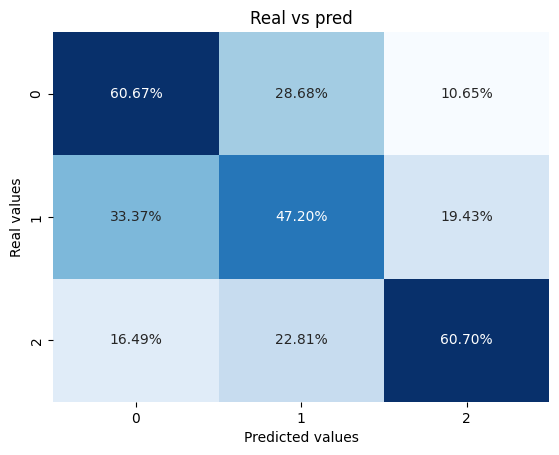

In [40]:
sns.heatmap(confusion_matrix(y_test,df_salida_3.predict, normalize = 'true'),
            annot=True,fmt='.2%', cmap = 'Blues', cbar = False);

plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

In [42]:
print(classification_report(y_test,df_salida_3.predict))

              precision    recall  f1-score   support

           0       0.63      0.61      0.62      2939
           1       0.40      0.47      0.43      1966
           2       0.67      0.61      0.64      2359

    accuracy                           0.57      7264
   macro avg       0.57      0.56      0.56      7264
weighted avg       0.58      0.57      0.58      7264



# Abordemos los emmbedings 

In [178]:

import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/nnlm-es-dim128/2")
X_train_embeddings = embed(X_train)
X_test_embeddings = embed(X_test)


In [231]:
train_embedding = pd.DataFrame(X_train_embeddings.numpy())
train_emb = train_embedding
train_emb['y'] = df_initial['classification']
train_emb = train_emb.dropna()

In [232]:
train_embedding_ = h2o.H2OFrame(train_emb, column_names=train_emb.columns.astype(str).to_list(), column_types = {'y': 'enum'})
train_embedding_ = train_embedding_.na_omit()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [194]:
X_train_embb = train_embedding_.columns
X_train_embb.remove('y')

In [195]:
Y_train = 'y'

In [234]:
aml_2 = H2OAutoML(max_models=40, seed=1)
aml_2.train(x=X_train_embb, y=Y_train, training_frame=train_embedding_)

# View the AutoML Leaderboard
lb_2 = aml_2.leaderboard
lb_2.head(rows=lb_2.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |
10:41:52.36: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


model_id,mean_per_class_error,logloss,rmse,mse
DeepLearning_grid_3_AutoML_3_20230501_104152_model_1,0.653346,1.23254,0.681989,0.465109
DRF_1_AutoML_3_20230501_104152,0.655865,1.10938,0.665275,0.44259
DeepLearning_grid_3_AutoML_3_20230501_104152_model_6,0.657262,1.09819,0.662119,0.438401
GBM_grid_1_AutoML_3_20230501_104152_model_13,0.657466,1.14969,0.67166,0.451127
DeepLearning_grid_2_AutoML_3_20230501_104152_model_3,0.658725,1.2257,0.676383,0.457494
DeepLearning_grid_2_AutoML_3_20230501_104152_model_5,0.659894,1.14693,0.671739,0.451233
GBM_3_AutoML_3_20230501_104152,0.659981,1.10476,0.664823,0.44199
GBM_4_AutoML_3_20230501_104152,0.660259,1.11319,0.666268,0.443914
XRT_1_AutoML_3_20230501_104152,0.66055,1.10654,0.664487,0.441542
GBM_grid_1_AutoML_3_20230501_104152_model_11,0.6608,1.09351,0.663196,0.43983


In [235]:
test_embeddings = pd.DataFrame(X_test_embeddings.numpy())
test_embed = test_embeddings
test_embed['y'] = df_final.classification


test_embed_ = h2o.H2OFrame(test_embed, column_names=test_embed.columns.astype(str).to_list(), column_types = {'y': 'enum'})
test_embed_ = test_embed_.na_omit()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [236]:
m_2 = aml_2.get_best_model()


In [238]:
preds_2 = m_2.predict(test_embed_)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


In [240]:
df_salida_2 = preds_2.as_data_frame()

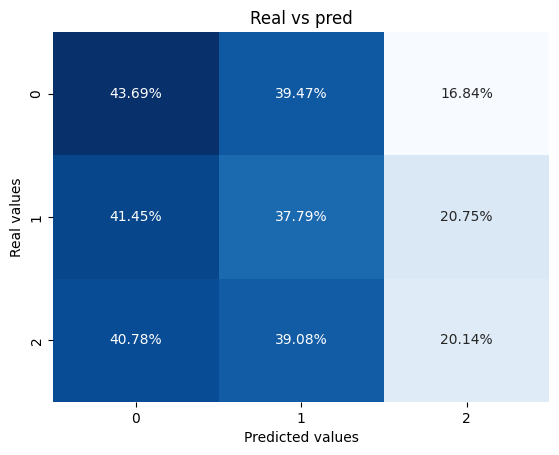

In [242]:
sns.heatmap(confusion_matrix(y_test,df_salida_2.predict, normalize = 'true'),
            annot=True,fmt='.2%', cmap = 'Blues', cbar = False);

plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

In [243]:
print(classification_report(y_test,df_salida_2.predict))

              precision    recall  f1-score   support

           0       0.42      0.44      0.43      2939
           1       0.26      0.38      0.31      1966
           2       0.34      0.20      0.25      2359

    accuracy                           0.34      7264
   macro avg       0.34      0.34      0.33      7264
weighted avg       0.35      0.34      0.34      7264

